# Create hdf5 datasets from the raw images (only 0, 90, 180, 270 rots)

This notebook requires the raw agrovision dataset. You most likely shouldn't have to re-run it.

In [1]:
import sys
sys.path.append('..')

import os
import numpy as np
import numpy.ma as ma
import pylab as pl
import agronn.classif2 as classif2
import agronn.dataio as dataio
import agronn.utils as utils
import cPickle as pickle
import matplotlib.cm as cm
import skimage
import unidecode
import sklearn.cross_validation as skcv
import skimage.color as skcolor
from keras.utils import np_utils
%matplotlib inline

np.random.seed(1337) # for reproducibility
np.set_printoptions(precision=5, suppress=True)

reload(classif2)

<module 'agronn.classif2' from 'agronn/classif2.pyc'>

23 classes


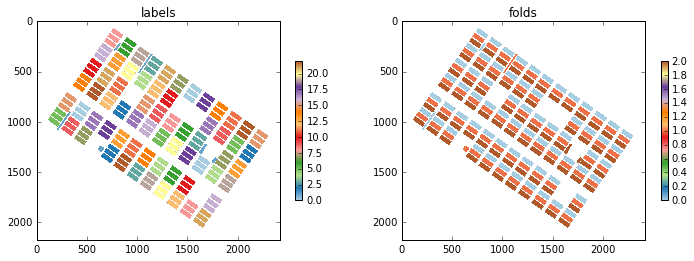

In [2]:
labels, id2label, folds, _ = classif2.load_labels(4)
id2label = np.array([unidecode.unidecode(l) for l in id2label])
nclasses = len(id2label)

print len(id2label), 'classes'

pl.figure(figsize=(12, 5))
pl.subplot(121)
pl.title('labels')
pl.imshow(labels, cmap=cm.Paired)
pl.colorbar(shrink=0.5)

pl.subplot(122)
pl.title('folds')
pl.imshow(folds, cmap=cm.Paired)
pl.colorbar(shrink=0.5)

In [3]:
for lab in id2label:
    print lab, "|",

Avoine | Bare soil | CC4CA | Chanvre | Chia | Feverole | Lentille | Lin | M blanche | Moha | Navette | Niger | Phacelie | Pois | R chinois | R fourrager | Sarepta | Sarrasin | Simplex | Sorgho | Tournesol | Trefle | Vesce |


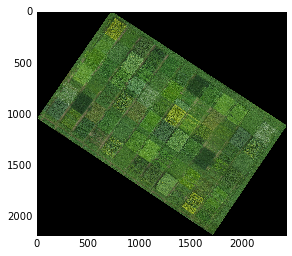

In [4]:
img_rgb = classif2.load_image('2013_10_08', 'rgb')
img_rgb = skimage.img_as_float(img_rgb).astype(np.float32)
pl.imshow(img_rgb)

In [5]:
def sample(arr, num):
    """
    Sample num entries along the first dimension of arr
    """
    indices = np.random.choice(np.arange(len(arr)), num, replace=False)
    return arr[indices]

def ij_to_mask(ij, imshape):
    mask = np.zeros(imshape, dtype=np.bool)
    mask[ij[:,0], ij[:,1]] = True
    
def extract_labels(labels, ij):
    y = labels[ij[:,0], ij[:,1]].filled(-1)
    assert not np.any(y == -1), "Unlabeled points"
    return y


In [6]:
rot_angles=[0, 90, 180, 270]
mosaic_builder = utils.RotatedImageMosaicBuilder(img_rgb, rot_angles)
mosaic = mosaic_builder.get_mosaic()

In [7]:
print "mosaic shape ", mosaic.shape
#pl.imshow(img_mosaic[10000:15000])

print "mosaic takes ", mosaic.nbytes / (1024. * 1024.), "mb"

mosaic shape  (13724, 3431, 3)
mosaic takes  1077.73690796 mb


In [8]:
ntrain = 40000
ntest = 20000

So we have 3 different way of doing the folds (which are stored in files named labels_4, labels_5 and labels_6), so 3 different "datasets". And then, for each way of doing the folds, we have 3 folds.

For a given way of doing the folds, we will generate 3 datasets with 2 folds as train and one fold as test, so :

1. train = [1, 2], test = 0
2. train = [0, 2], test = 1
3. train = [0, 1], test = 2

This will give us a total of 9 datasets. For each dataset, we sample ntrain and ntest points. We do this sampling 10 times.

In the HDF5 file, the dataset are named ``labels_<number>_test_fold_<test fold>_rep_<int>``

In [9]:
data = {
    'img' : img_rgb,
    'mosaic' : mosaic,
    'padded_shape' : mosaic_builder.padded_shape,
    'id2label' : id2label,
    'rot_angles' : rot_angles,
    'experiments' : {}
}

for datasetid in [4, 5, 6]:
    labels, _id2label, folds, _ = classif2.load_labels(datasetid)
    _id2label = np.array([unidecode.unidecode(l) for l in _id2label])
    assert np.all(_id2label == id2label)
    data['labels_%d' % datasetid] = {
        'labels': labels.filled(-1),
        'folds': folds,
    }
    
    for test_fold in [0, 1, 2]:
        for rep in xrange(10):
            name = 'labels_%d_test_fold_%d_rep_%d' % (datasetid, test_fold, rep)
            print 'name : ', name
            train_candidates = np.transpose(np.nonzero(np.logical_and(~labels.mask,
                                                                      folds != test_fold)))
            test_candidates = np.transpose(np.nonzero(np.logical_and(~labels.mask,
                                                                      folds == test_fold)))
            train_ij = sample(train_candidates, ntrain).astype(np.int16)
            test_ij = sample(test_candidates, ntest).astype(np.int16)

            y_train = extract_labels(labels, train_ij)
            y_test = extract_labels(labels, test_ij)
            
            train_ij, y_train, test_ij, y_test = mosaic_builder.transform_ij_y(
                train_ij, y_train, test_ij, y_test)

            data['experiments'][name] = {
                'train_ij' : train_ij,
                'test_ij' : test_ij,
                'y_train' : y_train,
                'y_test' : y_test
            }

name :  labels_4_test_fold_0_rep_0
name :  labels_4_test_fold_0_rep_1
name :  labels_4_test_fold_0_rep_2
name :  labels_4_test_fold_0_rep_3
name :  labels_4_test_fold_0_rep_4
name :  labels_4_test_fold_0_rep_5
name :  labels_4_test_fold_0_rep_6
name :  labels_4_test_fold_0_rep_7
name :  labels_4_test_fold_0_rep_8
name :  labels_4_test_fold_0_rep_9
name :  labels_4_test_fold_1_rep_0
name :  labels_4_test_fold_1_rep_1
name :  labels_4_test_fold_1_rep_2
name :  labels_4_test_fold_1_rep_3
name :  labels_4_test_fold_1_rep_4
name :  labels_4_test_fold_1_rep_5
name :  labels_4_test_fold_1_rep_6
name :  labels_4_test_fold_1_rep_7
name :  labels_4_test_fold_1_rep_8
name :  labels_4_test_fold_1_rep_9
name :  labels_4_test_fold_2_rep_0
name :  labels_4_test_fold_2_rep_1
name :  labels_4_test_fold_2_rep_2
name :  labels_4_test_fold_2_rep_3
name :  labels_4_test_fold_2_rep_4
name :  labels_4_test_fold_2_rep_5
name :  labels_4_test_fold_2_rep_6
name :  labels_4_test_fold_2_rep_7
name :  labels_4_tes

In [10]:
print 'Num datasets : ', len(data['experiments'].keys())

Num datasets :  90


In [11]:
dataio.dict_to_hdf('../data_rot90_final.hdf5', data)